In [152]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from pandas_datareader import data
import matplotlib.pyplot as plt
from scipy.stats import norm
import pyfolio as pf
%matplotlib inline

In [167]:
import csv
df = pd.read_csv('Final_stock_data_V2.csv')
df

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,beta,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y
0,AAP,Advance Auto Parts Inc.,Consumer Cyclical,Increase,Above Fair Price,UnderValued,Sustainable,214.1500,0.103398,1.308405e+10,...,1.25,9.550,0.1525,13.932986,22.424082,109.188247,12.97,0.171149,0.355467,0.049267
1,ABT,Abbott Laboratories,Healthcare,Increase,Above Fair Price,OverValued,Average,118.2900,0.181179,2.091710e+11,...,0.74,3.940,0.1318,22.924420,30.022842,51.234756,25.96,0.109154,0.249769,0.247649
2,ACN,Accenture plc,Technology,Increase,Above Fair Price,OverValued,Sustainable,323.9050,0.208836,2.047083e+11,...,1.21,9.613,0.1135,31.025385,33.694477,121.148794,9.45,0.166287,0.254874,0.245322
3,ADM,Archer-Daniels-Midland Company,Consumer Defensive,Increase,Above Fair Price,OverValued,Not Sustainable,76.9850,0.122815,4.327843e+10,...,0.81,4.790,0.0660,14.804809,16.072025,19.449588,36.42,0.117663,0.252289,0.150693
4,ADP,"Automatic Data Processing, Inc.",Industrials,Increase,Above Fair Price,OverValued,Sustainable,201.0100,0.182708,8.443324e+10,...,0.83,6.460,0.1371,26.483530,31.116098,90.801919,14.18,0.120094,0.272415,0.178939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,XRX,Xerox Holdings Corporation,Technology,Increase,Above Fair Price,UnderValued,No Data,20.6059,0.029031,3.678401e+09,...,1.75,1.459,-0.1600,10.302950,14.123303,0.609810,999.00,0.231929,0.405374,-0.032851
934,ZD,"Ziff Davis, Inc.",Communication Services,Increase,Above Fair Price,OverValued,No Data,102.4800,0.145864,4.941668e+09,...,1.01,4.120,0.1140,14.193907,24.873789,38.485339,999.00,0.141975,0.308007,0.055993
935,ZUMZ,Zumiez Inc.,Consumer Cyclical,Decrease,Above Fair Price,UnderValued,No Data,42.6600,0.035214,9.777245e+08,...,1.68,4.870,0.1500,9.233767,8.759754,21.330001,999.00,0.223419,0.513665,0.157523
936,ESNT,Essent Group Ltd.,Financial Services,Increase,Above Fair Price,UnderValued,No Data,44.4800,0.082041,4.912015e+09,...,1.33,5.569,0.1555,7.339934,7.987071,23.215807,999.00,0.180874,0.502764,0.045034


<AxesSubplot:>

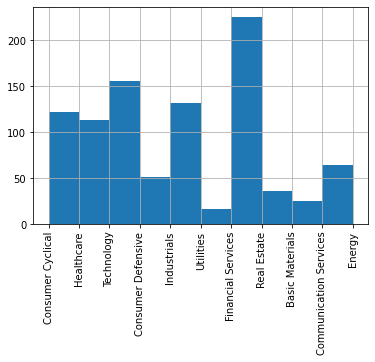

In [168]:
df['sector'].hist(xrot=90)

## Filter based on 2/3 criteria

In [169]:
def check_criteria(each):
    check = []
    if each["capm_status"] == "UnderValued":
        check.append(True)
    if each["Earnings_expectation"] == "Increase":
        check.append(True)
    if each["irv_status"] == "Below Fair Price":
        check.append(True)
    return check

In [170]:
def check_number(criteria):
    if len(criteria) >= 2:
        return True
    else:
        return False

In [171]:
rows = []
for i in range(938):
    each = df.iloc[i]
    criteria = check_criteria(each)
    result = check_number(criteria)
    if result:
        rows.append(i)

In [172]:
len(rows)

476

In [173]:
df = df.iloc[rows]
df

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,beta,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y
0,AAP,Advance Auto Parts Inc.,Consumer Cyclical,Increase,Above Fair Price,UnderValued,Sustainable,214.1500,0.103398,1.308405e+10,...,1.25,9.550,0.1525,13.932986,22.424082,109.188247,12.97,0.171149,0.355467,0.049267
5,ADSK,"Autodesk, Inc.",Technology,Increase,Below Fair Price,UnderValued,Sustainable,217.3800,0.190997,4.781773e+10,...,1.43,5.928,0.2883,31.967648,36.670040,302.038344,15.45,0.193030,0.384894,0.209161
11,ALK,"Alaska Air Group, Inc.",Industrials,Increase,Above Fair Price,UnderValued,No Data,58.9750,0.141697,7.425660e+09,...,1.55,3.770,-0.2340,9.073076,15.643236,0.761055,999.00,0.207617,0.454054,-0.086043
12,ALLE,Allegion plc,Industrials,Increase,Above Fair Price,UnderValued,Average,114.1447,0.097180,1.023831e+10,...,1.14,5.086,0.0777,19.955368,22.442923,31.814578,23.59,0.157777,0.279213,0.118004
14,AMD,"Advanced Micro Devices, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,117.1100,0.319034,1.414232e+11,...,1.95,3.242,0.3532,35.062874,36.122765,253.245268,999.00,0.256240,0.564107,0.569607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,XOMA,XOMA Corporation,Healthcare,Increase,Above Fair Price,UnderValued,No Data,20.7600,-0.034853,2.348205e+08,...,0.81,0.082,0.1900,-90.260870,253.170730,14.120154,999.00,0.117663,0.689078,0.371572
932,XP,XP Inc.,Financial Services,Increase,Above Fair Price,UnderValued,No Data,34.1100,-0.001020,1.908622e+10,...,1.91,0.986,0.0478,27.508064,34.594322,7.380346,999.00,0.251378,NaN,NaN
933,XRX,Xerox Holdings Corporation,Technology,Increase,Above Fair Price,UnderValued,No Data,20.6059,0.029031,3.678401e+09,...,1.75,1.459,-0.1600,10.302950,14.123303,0.609810,999.00,0.231929,0.405374,-0.032851
936,ESNT,Essent Group Ltd.,Financial Services,Increase,Above Fair Price,UnderValued,No Data,44.4800,0.082041,4.912015e+09,...,1.33,5.569,0.1555,7.339934,7.987071,23.215807,999.00,0.180874,0.502764,0.045034


In [174]:
#total number of stocks for each sector 

df["sector"].value_counts()

Industrials               93
Technology                89
Consumer Cyclical         79
Financial Services        68
Healthcare                52
Communication Services    29
Basic Materials           20
Consumer Defensive        19
Energy                    15
Real Estate               11
Utilities                  1
Name: sector, dtype: int64

In [175]:
#df for each sector

df_basic_materials = df.loc[df['sector'] == 'Basic Materials']
df_communication = df.loc[df['sector'] == 'Communication Services']
df_consumer_c = df.loc[df['sector'] == 'Consumer Cyclical']
df_consumer_d = df.loc[df['sector'] == 'Consumer Defensive']
df_energy = df.loc[df['sector'] == 'Energy']
df_financial = df.loc[df['sector'] == 'Financial Services']
df_healthcare = df.loc[df['sector'] == 'Healthcare']
df_industrials = df.loc[df['sector'] == 'Industrials']
df_real_estate = df.loc[df['sector'] == 'Real Estate']
df_tech = df.loc[df['sector'] == 'Technology']
df_utilites = df.loc[df['sector'] == 'Utilities']

## Selection of Sector based on Returns

In [176]:
#calculating the average returns

basic_returns = df_basic_materials['annu_return_5y'].mean()
comm_returns = df_communication['annu_return_5y'].mean()
consumer_c_returns = df_consumer_c['annu_return_5y'].mean()
consumer_d_returns = df_consumer_d['annu_return_5y'].mean()
energy_returns = df_energy['annu_return_5y'].mean()
financial_returns = df_financial['annu_return_5y'].mean()
healthcare_returns = df_healthcare['annu_return_5y'].mean()
industrials_returns = df_industrials['annu_return_5y'].mean()
real_estate_returns = df_real_estate['annu_return_5y'].mean()
tech_returns = df_tech['annu_return_5y'].mean()
utilities_returns = df_utilites['annu_return_5y'].mean()

print(tabulate([['Basic Materials', basic_returns],['Communication Services', comm_returns],['Consumer Cyclical', consumer_c_returns],['Consumer Defensive', consumer_d_returns], ['Energy', energy_returns], ['Financial Services', financial_returns], ['Healthcare', healthcare_returns], ['Industrials', industrials_returns], ['Real Estate', real_estate_returns], ['Technology', tech_returns], ['Utilities', utilities_returns]],
               headers=['Sector','Annual Returns']))

Sector                    Annual Returns
----------------------  ----------------
Basic Materials                0.0631966
Communication Services         0.0340231
Consumer Cyclical              0.0942812
Consumer Defensive             0.049066
Energy                         0.0551988
Financial Services             0.03874
Healthcare                     0.101074
Industrials                    0.0855473
Real Estate                    0.106064
Technology                     0.123625
Utilities                      0.118782


From above, the top 3 sectors that give the highest returns is Technology (0.123625), Utilities (0.118782), Real Estate (0.106064). These will be the chosen sectors for the aggressive model. 

In [177]:
#combining the top 3 sectors into 1 dataframe

df2 = pd.concat([df_tech, df_utilites, df_real_estate])
df2

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,beta,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y
5,ADSK,"Autodesk, Inc.",Technology,Increase,Below Fair Price,UnderValued,Sustainable,217.3800,0.190997,4.781773e+10,...,1.43,5.928,0.2883,31.967648,36.670040,302.038344,15.45,0.193030,0.384894,0.209161
14,AMD,"Advanced Micro Devices, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,117.1100,0.319034,1.414232e+11,...,1.95,3.242,0.3532,35.062874,36.122765,253.245268,999.00,0.256240,0.564107,0.569607
17,ANSS,"ANSYS, Inc.",Technology,Increase,Above Fair Price,UnderValued,Sustainable,305.4575,0.163292,2.665208e+10,...,1.24,5.318,0.1118,38.470715,57.438416,112.688671,13.16,0.169933,0.316793,0.271663
57,CTSH,Cognizant Technology Solutions,Technology,Increase,Above Fair Price,UnderValued,Sustainable,85.7600,0.098598,4.556764e+10,...,1.13,3.545,0.1398,18.973452,24.191820,39.576018,17.47,0.156562,0.290279,0.115536
73,EPAM,"EPAM Systems, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,428.8350,0.408649,2.432335e+10,...,1.43,7.211,0.2850,38.391674,59.469560,582.247739,999.00,0.193030,0.376405,0.422642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,GOOD,Gladstone Commercial Corporatio,Real Estate,Increase,Above Fair Price,UnderValued,No Data,21.0900,0.095257,7.859906e+08,...,1.00,0.029,0.0600,-2109.000000,727.241400,5.064293,999.00,0.140759,0.386789,0.084844
581,LAMR,Lamar Advertising Company,Real Estate,Increase,Above Fair Price,UnderValued,Sustainable,109.8500,0.167806,1.112110e+10,...,1.44,3.689,0.0300,23.422174,29.777718,20.371571,16.28,0.194245,0.413550,0.128521
614,LSEA,Landsea Homes Corporation,Real Estate,Increase,Below Fair Price,UnderValued,No Data,6.5600,-0.037662,3.036040e+08,...,0.14,0.531,0.4860,4.315790,12.354049,32.942956,999.00,0.036218,NaN,NaN
906,UNIT,Uniti Group Inc.,Real Estate,Increase,Below Fair Price,UnderValued,No Data,11.0850,-0.039440,2.616847e+09,...,1.05,0.171,0.3400,17.879032,64.824560,21.946654,999.00,0.146837,0.546158,-0.087307


## Filtering Stocks based on Sharpe Ratio

In [178]:
def get_closeprice(ticker):    
    start_date = str(date.today().year - 5) +'-0'+ str(date.today().month) +'-'+ str(date.today().day)
    end_date = str(date.today())
    
    panel_data = data.DataReader([ticker],'yahoo', start_date, end_date)
    closes = panel_data[["Close", "Adj Close"]]
    
    return closes

In [179]:
def get_sharpe_ratio(ticker):
    
    closes = get_closeprice(ticker)
    adj_close = closes["Adj Close"]
    
    risk_free_ann_ret_rate = 0.0195  #assuming this rate based on the latest data
     
    #Rp
    returns_ts = adj_close.pct_change().dropna()
    
    #Average Rp
    avg_daily_ret = returns_ts.mean()

    #Average risk-free rate for the year (Annual rate / number of trading days to spread it out)
    returns_ts['RiskFree_Rate'] = risk_free_ann_ret_rate/252

    #Average Rf
    avg_rf_ret = returns_ts['RiskFree_Rate'].mean()

    #calculate sharpe ratio

    #Add the excess return columns for each ETF: Rp - Rf
    returns_ts['Excess_ret'] = returns_ts[ticker] - returns_ts['RiskFree_Rate']
    
    sharpe = ((avg_daily_ret[ticker] - avg_rf_ret) /returns_ts['Excess_ret'].std())*np.sqrt(252)

    return sharpe.round(3)

In [180]:
sharpe_list = []
for i in range(len(df2)):
    each = df2.iloc[i]
    ticker = each["ticker"]
    sharpe = get_sharpe_ratio(ticker)
    sharpe_list.append(sharpe)

C:\Users\LAVANYA MARAN\anaconda3\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'ANSS', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


RemoteDataError: No data fetched using 'YahooDailyReader'

In [ ]:
sharpe_list

In [ ]:
df2["sharpe"] = sharpe_list
df2

In [ ]:
#only choosing stocks which has a sharpe ratio of more than 0.6 

df3 = df2[df2["sharpe"] > 0.6]
df3

## Correlation between Stocks

In [ ]:
def get_return_series(ticker):
    closes = get_closeprice(ticker)
    return_series_close = (closes['Close'].pct_change()+ 1).cumprod() - 1
    return return_series_close

In [ ]:
returns_list = []
for i in range(len(df3)):
    each = df3.iloc[i]
    ticker = each["ticker"]
    returns = get_return_series(ticker)
    if (len(returns) == 1260):
        returns_list.append(returns)

In [51]:
returns_list

[Symbols          AMD
 Date                
 2017-03-17       NaN
 2017-03-20  0.067457
 2017-03-21  0.024463
 2017-03-22  0.045219
 2017-03-23  0.022239
 ...              ...
 2022-03-11  6.730912
 2022-03-14  6.579689
 2022-03-15  7.104522
 2022-03-16  7.552261
 2022-03-17  7.177168
 
 [1260 rows x 1 columns],
 Symbols         ANSS
 Date                
 2017-03-17       NaN
 2017-03-20  0.002237
 2017-03-21 -0.008109
 2017-03-22 -0.006058
 2017-03-23 -0.006524
 ...              ...
 2022-03-11  1.736695
 2022-03-14  1.702395
 2022-03-15  1.778358
 2022-03-16  1.897940
 2022-03-17  1.869699
 
 [1260 rows x 1 columns],
 Symbols         EPAM
 Date                
 2017-03-17       NaN
 2017-03-20  0.001517
 2017-03-21 -0.006345
 2017-03-22  0.000966
 2017-03-23  0.004966
 ...              ...
 2022-03-11  1.760552
 2022-03-14  2.034483
 2022-03-15  2.104000
 2022-03-16  2.885793
 2022-03-17  2.774414
 
 [1260 rows x 1 columns],
 Symbols         QCOM
 Date                
 2017-03-17   

In [52]:
return_series_close = pd.concat(returns_list, axis=1)
return_series_close

Symbols,AMD,ANSS,EPAM,QCOM,AOSL,APPS,ASML,AUDC,DIOD,DSGX,...,NSIT,ON,POWI,RIOT,TTD,UCTT,WDAY,CBRE,EQIX,SBAC
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-20,0.067457,0.002237,0.001517,0.004518,-0.016366,-0.032967,0.002893,-0.017094,-0.009346,-0.010893,...,-0.024240,0.000000,-0.008191,-0.008982,-0.035687,0.025243,0.006356,-0.013322,0.021111,0.012192
2017-03-21,0.024463,-0.008109,-0.006345,-0.013032,-0.053612,-0.032967,-0.012353,-0.041311,-0.043072,-0.010893,...,-0.067688,-0.038689,-0.049144,-0.041916,-0.049608,-0.030421,-0.036959,-0.024147,0.020685,0.012365
2017-03-22,0.045219,-0.006058,0.000966,-0.008862,-0.046275,-0.010989,0.007975,-0.052707,-0.047542,0.002179,...,-0.064487,-0.022295,-0.046165,0.044910,-0.022020,-0.025243,-0.041314,-0.031918,0.031493,0.010636
2017-03-23,0.022239,-0.006524,0.004966,-0.012858,-0.030474,0.043956,0.010321,-0.025641,-0.036164,0.002179,...,-0.052138,-0.019016,-0.048399,-0.002994,-0.063022,-0.004531,-0.041078,-0.029975,0.033037,0.021444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-11,6.730912,1.736695,1.760552,1.647089,1.729684,37.318679,3.580531,2.767806,2.340105,2.081046,...,1.386920,2.664918,1.595979,3.532934,13.376107,1.588997,1.647246,1.430475,0.846316,1.774578
2022-03-14,6.579689,1.702395,2.034483,1.455082,1.536117,33.626373,3.515637,2.652422,2.321008,2.111982,...,1.377315,2.535082,1.503053,3.239521,12.282713,1.453075,1.600165,1.425756,0.819827,1.773022
2022-03-15,7.104522,1.778358,2.104000,1.505821,1.745486,34.802199,3.665364,2.710826,2.450630,2.096732,...,1.409101,2.715410,1.620998,3.464072,12.634523,1.533981,1.606168,1.430475,0.867852,1.786338


<AxesSubplot:xlabel='Date'>

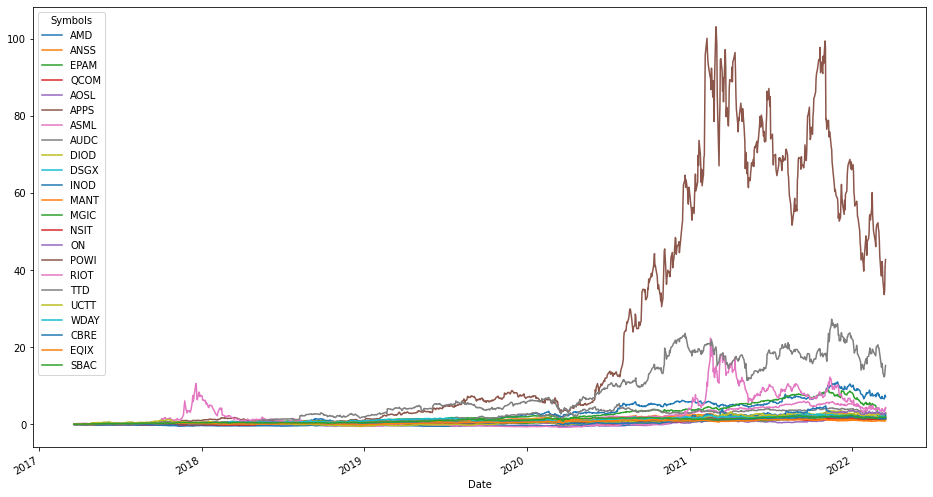

In [53]:
return_series_close.plot(figsize=(16,9))

In [54]:
highest = return_series_close[return_series_close.tail(1) > 5]

In [55]:
highest.dropna(axis=1, how="all")

Symbols,AMD,APPS,TTD
Date,,,
2017-03-17,NaN,NaN,NaN
2017-03-20,NaN,NaN,NaN
2017-03-21,NaN,NaN,NaN
2017-03-22,NaN,NaN,NaN
2017-03-23,NaN,NaN,NaN
...,...,...,...
2022-03-11,NaN,NaN,NaN
2022-03-14,NaN,NaN,NaN
2022-03-15,NaN,NaN,NaN


<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

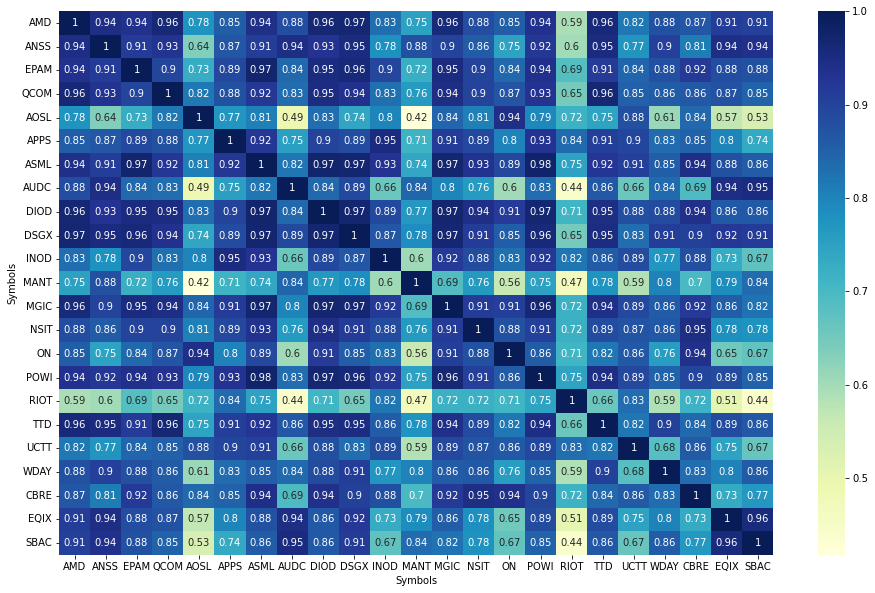

In [56]:
correlation = return_series_close.corr()
# correlation
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(correlation, annot = True, ax = ax, cmap="YlGnBu")

In [57]:
correlation = correlation[correlation < 0.1]
correlation

Symbols,AMD,ANSS,EPAM,QCOM,AOSL,APPS,ASML,AUDC,DIOD,DSGX,...,NSIT,ON,POWI,RIOT,TTD,UCTT,WDAY,CBRE,EQIX,SBAC
Symbols,,,,,,,,,,,,,,,,,,,,,
AMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EPAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QCOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AOSL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ASML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUDC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Final DF

In [58]:
all_stocks = []
for each in correlation:
    all_stocks.append(each)

In [59]:
indexes = []
for i in range(len(df3)):
    each = df3.iloc[i]
    ticker = each["ticker"]
    if ticker in all_stocks:
        indexes.append(i)

In [60]:
chosen_df = df3.iloc[indexes]
chosen_df

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y,sharpe
14,AMD,"Advanced Micro Devices, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,117.1100,0.319034,1.414232e+11,...,3.242,0.3532,35.062874,36.122765,253.245268,999.00,0.256240,0.564107,0.569607,0.993
17,ANSS,"ANSYS, Inc.",Technology,Increase,Above Fair Price,UnderValued,Sustainable,305.4575,0.163292,2.665208e+10,...,5.318,0.1118,38.470715,57.438416,112.688671,13.16,0.169933,0.316793,0.271663,0.757
73,EPAM,"EPAM Systems, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,428.8350,0.408649,2.432335e+10,...,7.211,0.2850,38.391674,59.469560,582.247739,999.00,0.193030,0.376405,0.422642,0.784
176,QCOM,QUALCOMM Incorporated,Technology,Increase,Below Fair Price,UnderValued,Sustainable,165.6500,0.130769,1.855280e+11,...,7.870,0.2562,14.231099,21.048285,183.404501,18.00,0.173580,0.375961,0.297623,0.722
243,AOSL,Alpha and Omega Semiconductor L,Technology,Increase,Above Fair Price,UnderValued,No Data,49.2600,0.165397,1.299356e+09,...,2.612,0.1700,11.617925,18.859112,28.764485,999.00,0.330391,0.570794,0.201750,0.637
244,APPS,"Digital Turbine, Inc.",Technology,Increase,Below Fair Price,UnderValued,No Data,43.8000,0.278657,4.232205e+09,...,0.530,0.5000,20.372091,82.641510,239.323247,999.00,0.285415,0.719036,1.325025,1.365
249,ASML,ASML Holding N.V. - New York Re,Technology,Increase,Below Fair Price,OverValued,No Data,634.7900,0.341963,2.580256e+11,...,15.017,0.2980,32.420326,42.271423,943.608234,999.00,0.134681,0.360669,0.411064,1.045
258,AUDC,AudioCodes Ltd.,Technology,Increase,Below Fair Price,OverValued,No Data,27.6750,0.234188,9.141052e+08,...,1.028,0.2500,16.875000,26.921206,29.306718,999.00,0.084842,0.446357,0.362672,0.833
381,DIOD,Diodes Incorporated,Technology,Increase,Above Fair Price,UnderValued,No Data,87.1300,0.131229,3.922401e+09,...,4.123,0.1500,14.919519,21.132670,43.564999,999.00,0.148053,0.401822,0.286506,0.784
386,DSGX,The Descartes Systems Group Inc,Technology,Increase,Below Fair Price,OverValued,No Data,69.6200,0.240316,5.893862e+09,...,0.980,0.2600,66.942314,71.040820,79.206056,999.00,0.144406,0.291432,0.265617,0.876


In [61]:
chosen_df.to_csv("selected_stocks_aggressive.csv")

## Bonds

In [181]:
pip install Nasdaq-Data-Link

Note: you may need to restart the kernel to use updated packages.


In [182]:
pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [183]:
import nasdaqdatalink
import quandl

In [184]:
quandl.get('USTREASURY/YIELD')['5 YR']
#expected return from US 5y treasury bond is 1.78

Date
1990-01-02    7.87
1990-01-03    7.92
1990-01-04    7.91
1990-01-05    7.92
1990-01-08    7.92
              ... 
2022-01-31    1.62
2022-02-01    1.63
2022-02-02    1.60
2022-02-03    1.66
2022-02-04    1.78
Name: 5 YR, Length: 8032, dtype: float64

## Aggressive Model 1: 70% Stocks & 30% Bonds

In [ ]:
def calculate_returns(weights, log_returns):
    # Annual log Returns

    return np.sum(log_returns.mean()*weights) * 252

In [ ]:
n = len(adjClose_5y[top_40_ret_data['ticker']].columns)
log_returns_test = np.log(adjClose_5y[top_40_ret_data['ticker']] / adjClose_5y[top_40_ret_data['ticker']].shift(1)).dropna() # Same as 1 + stocks_data.pct_change()
log_returns_test

In [ ]:
def function_to_minimize(weights):

    # minimize a -1 * SR (that's how the math works here, but it is the same as maximizing SR)
    return -1 * ((calculate_returns(weights, log_returns_test) - 0 )/calculate_volatility(weights, log_returns_test)) # assuming rf =0

In [ ]:
required_return = 0.70
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_returns(weights,log_returns_test) - required_return})
bounds = tuple((0,1) for n in range(n))
equal_weights = n * [1/n] #going to be our starting point then the function will look at either direction for minimum negative SG

In [ ]:
def calculate_vol(weights):
    annualized_cov = np.dot(log_returns_test.cov()*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

In [ ]:
result = minimize(fun=calculate_vol,x0=equal_weights,bounds=bounds,constraints=constraints)
result